In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import skimage.transform
import requests
#import urllib
import os
#from PIL import Image
#from skimage.filters import threshold_otsu
%matplotlib inline

In [2]:
# copied from https://gist.github.com/dbader/5488053

#!/usr/bin/env python
# -*- coding: utf-8 -*-
# Needs freetype-py>=1.0

# For more info see:
# http://dbader.org/blog/monochrome-font-rendering-with-freetype-and-python

# The MIT License (MIT)
#
# Copyright (c) 2013 Daniel Bader (http://dbader.org)
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

import freetype


class Bitmap(object):
    """
    A 2D bitmap image represented as a list of byte values. Each byte indicates the state
    of a single pixel in the bitmap. A value of 0 indicates that the pixel is `off`
    and any other value indicates that it is `on`.
    """
    def __init__(self, width, height, pixels=None):
        self.width = width
        self.height = height
        self.pixels = pixels or bytearray(width * height)

    def __repr__(self):
        """Return a string representation of the bitmap's pixels."""
        rows = ''
        for y in range(self.height):
            for x in range(self.width):
                rows += '#' if self.pixels[y * self.width + x] else '.'
            rows += '\n'
        return rows

    def bitblt(self, src, x, y):
        """Copy all pixels from `src` into this bitmap"""
        srcpixel = 0
        dstpixel = y * self.width + x
        row_offset = self.width - src.width

        for sy in range(src.height):
            for sx in range(src.width):
                # Perform an OR operation on the destination pixel and the source pixel
                # because glyph bitmaps may overlap if character kerning is applied, e.g.
                # in the string "AVA", the "A" and "V" glyphs must be rendered with
                # overlapping bounding boxes.
                self.pixels[dstpixel] = self.pixels[dstpixel] or src.pixels[srcpixel]
                srcpixel += 1
                dstpixel += 1
            dstpixel += row_offset


class Glyph(object):
    def __init__(self, pixels, width, height, top, advance_width):
        self.bitmap = Bitmap(width, height, pixels)

        # The glyph bitmap's top-side bearing, i.e. the vertical distance from the
        # baseline to the bitmap's top-most scanline.
        self.top = top

        # Ascent and descent determine how many pixels the glyph extends
        # above or below the baseline.
        self.descent = max(0, self.height - self.top)
        self.ascent = max(0, max(self.top, self.height) - self.descent)

        # The advance width determines where to place the next character horizontally,
        # that is, how many pixels we move to the right to draw the next glyph.
        self.advance_width = advance_width

    @property
    def width(self):
        return self.bitmap.width

    @property
    def height(self):
        return self.bitmap.height

    @staticmethod
    def from_glyphslot(slot):
        """Construct and return a Glyph object from a FreeType GlyphSlot."""
        pixels = Glyph.unpack_mono_bitmap(slot.bitmap)
        width, height = slot.bitmap.width, slot.bitmap.rows
        top = slot.bitmap_top

        # The advance width is given in FreeType's 26.6 fixed point format,
        # which means that the pixel values are multiples of 64.
        advance_width = slot.advance.x // 64

        return Glyph(pixels, width, height, top, advance_width)

    @staticmethod
    def unpack_mono_bitmap(bitmap):
        """
        Unpack a freetype FT_LOAD_TARGET_MONO glyph bitmap into a bytearray where each
        pixel is represented by a single byte.
        """
        # Allocate a bytearray of sufficient size to hold the glyph bitmap.
        data = bytearray(bitmap.rows * bitmap.width)

        # Iterate over every byte in the glyph bitmap. Note that we're not
        # iterating over every pixel in the resulting unpacked bitmap --
        # we're iterating over the packed bytes in the input bitmap.
        for y in range(bitmap.rows):
            for byte_index in range(bitmap.pitch):

                # Read the byte that contains the packed pixel data.
                byte_value = bitmap.buffer[y * bitmap.pitch + byte_index]

                # We've processed this many bits (=pixels) so far. This determines
                # where we'll read the next batch of pixels from.
                num_bits_done = byte_index * 8

                # Pre-compute where to write the pixels that we're going
                # to unpack from the current byte in the glyph bitmap.
                rowstart = y * bitmap.width + byte_index * 8

                # Iterate over every bit (=pixel) that's still a part of the
                # output bitmap. Sometimes we're only unpacking a fraction of a byte
                # because glyphs may not always fit on a byte boundary. So we make sure
                # to stop if we unpack past the current row of pixels.
                for bit_index in range(min(8, bitmap.width - num_bits_done)):

                    # Unpack the next pixel from the current glyph byte.
                    bit = byte_value & (1 << (7 - bit_index))

                    # Write the pixel to the output bytearray. We ensure that `off`
                    # pixels have a value of 0 and `on` pixels have a value of 1.
                    data[rowstart + bit_index] = 1 if bit else 0

        return data


class Font(object):
    def __init__(self, filename, size):
        self.face = freetype.Face(filename)
        self.face.set_pixel_sizes(0, size)

    def glyph_for_character(self, char):
        # Let FreeType load the glyph for the given character and tell it to render
        # a monochromatic bitmap representation.
        self.face.load_char(char, freetype.FT_LOAD_RENDER | freetype.FT_LOAD_TARGET_MONO)
        return Glyph.from_glyphslot(self.face.glyph)

    def render_character(self, char):
        glyph = self.glyph_for_character(char)
        return glyph.bitmap

    def kerning_offset(self, previous_char, char):
        """
        Return the horizontal kerning offset in pixels when rendering `char`
        after `previous_char`.

        Use the resulting offset to adjust the glyph's drawing position to
        reduces extra diagonal whitespace, for example in the string "AV" the
        bitmaps for "A" and "V" may overlap slightly with some fonts. In this
        case the glyph for "V" has a negative horizontal kerning offset as it is
        moved slightly towards the "A".
        """
        kerning = self.face.get_kerning(previous_char, char)

        # The kerning offset is given in FreeType's 26.6 fixed point format,
        # which means that the pixel values are multiples of 64.
        return kerning.x // 64

    def text_dimensions(self, text):
        """Return (width, height, baseline) of `text` rendered in the current font."""
        width = 0
        max_ascent = 0
        max_descent = 0
        previous_char = None

        # For each character in the text string we get the glyph
        # and update the overall dimensions of the resulting bitmap.
        for char in text:
            glyph = self.glyph_for_character(char)
            max_ascent = max(max_ascent, glyph.ascent)
            max_descent = max(max_descent, glyph.descent)
            kerning_x = self.kerning_offset(previous_char, char)

            # With kerning, the advance width may be less than the width of the glyph's bitmap.
            # Make sure we compute the total width so that all of the glyph's pixels
            # fit into the returned dimensions.
            width += max(glyph.advance_width + kerning_x, glyph.width + kerning_x)

            previous_char = char

        height = max_ascent + max_descent
        return (width, height, max_descent)

    def render_text(self, text, width=None, height=None, baseline=None):
        """
        Render the given `text` into a Bitmap and return it.

        If `width`, `height`, and `baseline` are not specified they are computed using
        the `text_dimensions' method.
        """
        if None in (width, height, baseline):
            width, height, baseline = self.text_dimensions(text)

        x = 0
        previous_char = None
        outbuffer = Bitmap(width, height)

        for char in text:
            glyph = self.glyph_for_character(char)

            # Take kerning information into account before we render the
            # glyph to the output bitmap.
            x += self.kerning_offset(previous_char, char)

            # The vertical drawing position should place the glyph
            # on the baseline as intended.
            y = height - glyph.ascent - baseline

            outbuffer.bitblt(glyph.bitmap, x, y)

            x += glyph.advance_width
            previous_char = char

        return outbuffer

#if __name__ == '__main__':
#    # Be sure to place 'helvetica.ttf' (or any other ttf / otf font file) in the working directory.
#    fnt = Font('Apple ][.ttf', 8)
#
#    # Single characters
#    ch = fnt.render_character('e')
#    print(repr(ch))
#
#    # Multiple characters
#    txt = fnt.render_text('hello')
#    print(repr(txt))
#
#    # Kerning
#    print(repr(fnt.render_text('AV Wa')))
#
#    # Choosing the baseline correctly
#    print(repr(fnt.render_text('hello, world.')))

In [3]:
DISPLAY_WIDTH = 96
DISPLAY_HEIGHT = 27

In [4]:
#FN = 'http://www.freeiconspng.com/uploads/blue-snow-icon-8.png'
#FN = 'http://www.freeiconspng.com/uploads/black-autumn-leaf-icon-7.jpeg'
#urllib.request.urlretrieve(FN, 'image')
#im = Image.open('image')

In [18]:
def pad_text_line(txtbmp): # bitmap object, display height, display width
    height = txtbmp.height
    width = txtbmp.width
    
    im = np.array(txtbmp.pixels)
    im.resize((height, width))
    im = np.hstack((im, np.zeros((height,DISPLAY_WIDTH-width))))
    im = np.vstack((np.zeros((1,DISPLAY_WIDTH)), im))
    if height < 6:
        im = np.vstack((im, np.zeros((1,DISPLAY_WIDTH))))
    
    return im

def stack_lines(line1, line2, line3, line4):
    return np.vstack((pad_text_line(line1), pad_text_line(line2), pad_text_line(line3), pad_text_line(line4)[:-1,:]))

In [17]:
#fnt = Font('Apple ][.ttf', 8)
fnt = Font('slkscr.ttf', 8)
line1 = fnt.render_text('hello makehaven')
line2 = fnt.render_text('@robbyblum')
line3 = fnt.render_text('Slack channel:')
line4 = fnt.render_text('road-sign-hacking')
print(line1)
print(line2)
print(line3)
print(line4)
print((line3.height, line3.width))


im = stack_lines(line1, line2, line3, line4)
#im = im2[:,0:96]
im.shape

#..#..###..#....#.....##.......#...#...##...#..#..###..#..#...##...#...#..###..#...#..
#..#..#....#....#....#..#......##.##..#..#..#.#...#....#..#..#..#..#...#..#....##..#..
####..###..#....#....#..#......#.#.#..####..##....###..####..####...#.#...###..#.#.#..
#..#..#....#....#....#..#......#...#..#..#..#.#...#....#..#..#..#...#.#...#....#..##..
#..#..###..###..###...##.......#...#..#..#..#..#..###..#..#..#..#....#....###..#...#..

.###...###....##...###...###...#...#..###...#....#..#..#...#..
#.#.#..#..#..#..#..#..#..#..#...#.#...#..#..#....#..#..##.##..
#.##...###...#..#..###...###.....#....###...#....#..#..#.#.#..
#......#.#...#..#..#..#..#..#....#....#..#..#....#..#..#...#..
.###...#..#...##...###...###.....#....###...###...##...#...#..

.###..#.....##....##...#..#.......##...#..#...##...#...#..#...#..###..#......
#.....#....#..#..#..#..#.#.......#..#..#..#..#..#..##..#..##..#..#....#....#.
.##...#....####..#.....##........#.....####..####..#.#.#..#.#.#..###..#......
...#..#....#..

(27, 96)

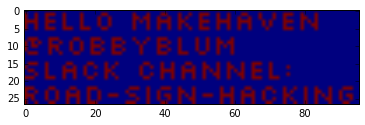

In [7]:
plt.imshow(im)

In [8]:
# put image data into C code string

s = 'static const unsigned char buf[] = {'
for y in range(DISPLAY_HEIGHT):
    for x in range(DISPLAY_WIDTH):
        s += '%d,' % im[DISPLAY_HEIGHT - 1 - y, x]
s = s[:-1]
s += '};'

In [9]:
with open('buf.h', 'w') as of:
    of.write(s)

In [10]:
# upload source to particle.io cloud firmware update

files = {'base.cpp': open('base.ino','rb'), 'buf.h': open('buf.h', 'rb')}
#files = {'base.cpp': open('scroll.ino','rb'), 'buf.h': open('buf.h', 'rb')}
url = 'https://api.particle.io/v1/devices/{}?access_token={}'.format(
    os.environ['PARTICLE_ID'],
    os.environ['TOKEN'])

r = requests.put(url,files=files)

print(r, r.text)

<Response [200]> {"ok":true,"message":"Update started"}


In [11]:
shrine = np.loadtxt('shrine.csv',dtype=int,delimiter=',')
shrine
cols = shrine.shape[1]
im = np.hstack((shrine, np.zeros((27, 96-cols))))
im.shape

(27, 96)

## 2017/05/31: Firming up the Procedures

My plan for this time around is to make proper procedures for the automatic conversion of strings into arrays of 1's and 0's. Basic flow is:

1. User (or web frontend) inputs a list of up to 4 strings
2. Python checks for errors: disallowed characters (ones not in my font) or over-length strings
3. Python converts to rendered text (Bitmap objects)
4. Python converts Bitmap objects to nparray: convert, pad, and stack arrays
5. Python writes to the buf.h file and uploads the Arduino code to the sign

Possible issues/considerations:

- Since this isn't a fixed-width font, string length will depend on what characters are in it. So that check should probably come after the text has been rendered?
- The guy who wrote the text rendering code mentioned that it could be optimized further. Look into that at some point?
- Once I have something that works, I should probably have a SRS PYTHON DVLPR look over it to make it """professional"""

In [84]:
def input_strings(strings):
    """
    This function might change in scope as I write it---I need to get 
    stuff on paper before I can make it pretty, I guess. For now, it 
    reads in the strings, counts them, and starts converting them to 
    rendered representations...
    
    """
    if len(strings) > 4:
        # raise an error, somehow...someone help me make this "correct"
        print("ERROR: Too many strings! Max = 4")
        return
        
    # if we don't have 4 strings, pad the tuple with empty strings
    strings += ("",)*(4 - len(strings))
    #print(strings)
    
    # make our font object...probably goes outside this function tbh
    fnt = Font('slkscr.ttf', 8)
    
    # make Bitmap versions of text strings
    # lines is a list of Bitmap objects
    lines = [fnt.render_text(i) for i in strings]
    
    # debugging checks:
    for i in lines:
        print(i)
    print(lines[0].width)
    print(lines[3].width)
    
    

In [86]:
test_strs = "one","two"
input_strings(test_strs)


.##...#...#..###..
#..#..##..#..#....
#..#..#.#.#..###..
#..#..#..##..#....
.##...#...#..###..

###..#...#...##...
.#...#.#.#..#..#..
.#...#.#.#..#..#..
.#...#.#.#..#..#..
.#....#.#....##...



18
0
